In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

foldername = '/content/drive/My Drive/github/gluformer'
assert foldername is not None, "[!] Enter the foldername."

# add path to .py code
import sys
sys.path.append(foldername)

Mounted at /content/drive


In [ ]:
# load libraries

import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.distributions.empirical_distribution import ECDF

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from gluformer.attention import *
from gluformer.encoder import *
from gluformer.decoder import *
from gluformer.embed import *
from gluformer.model import *
from gludata.data_loader import *
from utils.train import *
from utils.test import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load data
PATH = foldername + '/gludata/data/'
BATCH_SIZE = 1
LEN_PRED = 12
LEN_LABEL = 60
LEN_SEQ = 180

test_data = CGMData(PATH, 'test', [LEN_SEQ, LEN_LABEL, LEN_PRED])
test_data_loader = DataLoader(test_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=0, 
                              drop_last=False, 
                              collate_fn = collate_fn_custom)

In [ ]:
%%capture
LEN_PRED_MODEL = 12
LEN_LABEL = 60
LEN_SEQ = 180

# define model
D_MODEL = 512
D_FCN = 2048
N_HEADS = 12
R_DROP = 0.3
ACTIV = "relu"
NUM_ENC_LAYERS = 2
NUM_DEC_LAYERS = 1
DISTIL = True
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Gluformer(d_model=D_MODEL, 
                  n_heads=N_HEADS, 
                  d_fcn=D_FCN, 
                  r_drop=R_DROP, 
                  activ=ACTIV, 
                  num_enc_layers=NUM_ENC_LAYERS, 
                  num_dec_layers=NUM_DEC_LAYERS,
                  distil=DISTIL, 
                  len_pred=LEN_PRED_MODEL)
model.load_state_dict(torch.load(foldername + "/model_likeli.pth"))
model.train()
model = model.to(DEVICE)

In [ ]:
UPPER = 402
LOWER = 38
SCALE_1 = 5
SCALE_2 = 2
NUM_SAMPLES = 500

# compute test loss
test_loss_3 = []
test_loss_6 = []
test_loss_9 = []
test_loss_12 = []

test_loss_rmse_3 = []
test_loss_rmse_6 = []
test_loss_rmse_9 = []
test_loss_rmse_12 = []

trues = []
preds = []
input = []
calibration = [[] for i in range(12)]
sharpness = [[] for i in range(12)]

for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
  input.append((subj_id, batch_x))
  pred, true = predict_batch(subj_id = subj_id, 
                              batch_x=batch_x, 
                              batch_y=batch_y, 
                              batch_x_mark=batch_x_mark, 
                              batch_y_mark=batch_y_mark, 
                              len_pred=LEN_PRED, 
                              len_pred_model=LEN_PRED_MODEL,
                              len_label=LEN_LABEL, 
                              model=model, 
                              device=DEVICE)
  pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy()
  # transform back
  pred = (pred + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
  true = (true + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
  # compute ecdf
  pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, NUM_SAMPLES)).transpose((1, 0, 2))
  true = true.transpose((1,0,2)).reshape((true.shape[1], -1, NUM_SAMPLES)).transpose((1, 0, 2))[:, :, 0]
  trues.append(true)
  preds.append(pred)
  for i in range(12):
    ecdf = ECDF(pred[0, i, :])
    p = ecdf(true[0, i])
    calibration[i].append(p)
    sharpness[i].append(np.var(pred[0, i, :]))

  # compute errors
  pred = np.mean(pred, axis=2)
  # compute APE: 15 mins (3 points)
  ape_3 = np.mean(np.abs(true[:, :3] - pred[:, :3]) / true[:, :3])
  rmse_3 = np.sqrt(np.mean((true[:, :3] - pred[:, :3]) ** 2))
  # compute APE: 30 mins (6 points)
  ape_6 = np.mean(np.abs(true[:, :6] - pred[:, :6]) / true[:, :6])
  rmse_6 = np.sqrt(np.mean((true[:, :6] - pred[:, :6]) ** 2))
  # compute APE: 45 mins (9 points)
  ape_9 = np.mean(np.abs(true[:, :9] - pred[:, :9]) / true[:, :9])
  rmse_9 = np.sqrt(np.mean((true[:, :9] - pred[:, :9]) ** 2))
  # compute APE: full
  ape_12 = np.mean(np.abs(true - pred) / true)
  rmse_12 = np.sqrt(np.mean((true - pred) ** 2))

  test_loss_3.append(ape_3)
  test_loss_6.append(ape_6)
  test_loss_9.append(ape_9)
  test_loss_12.append(ape_12)
  test_loss_rmse_3.append(rmse_3)
  test_loss_rmse_6.append(rmse_6)
  test_loss_rmse_9.append(rmse_9)
  test_loss_rmse_12.append(rmse_12)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


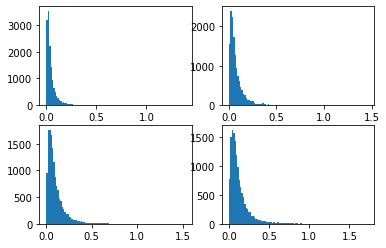

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].hist(np.array(test_loss_3), 100)
axarr[0,1].hist(np.array(test_loss_6), 100)
axarr[1,0].hist(np.array(test_loss_9), 100)
axarr[1,1].hist(np.array(test_loss_12), 100)
plt.show()

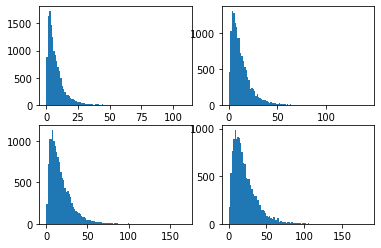

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].hist(np.array(test_loss_rmse_3), 100)
axarr[0,1].hist(np.array(test_loss_rmse_6), 100)
axarr[1,0].hist(np.array(test_loss_rmse_9), 100)
axarr[1,1].hist(np.array(test_loss_rmse_12), 100)
plt.show()

In [ ]:
print("Test loss for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(test_loss_3)), 
    np.median(np.array(test_loss_6)),
    np.median(np.array(test_loss_9)),
    np.median(np.array(test_loss_12))))

Test loss for 15 mins: 0.0299168, for 30 mins: 0.0515548, for 45 mins: : 0.0723735, for 60 mins: 0.0906065


In [ ]:
print("Test loss for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(test_loss_rmse_3)), 
    np.median(np.array(test_loss_rmse_6)),
    np.median(np.array(test_loss_rmse_9)),
    np.median(np.array(test_loss_rmse_12))))

Test loss for 15 mins: 5.6662087, for 30 mins: 9.9937220, for 45 mins: : 13.9683018, for 60 mins: 17.3688278


In [ ]:
calibration_matrix = np.empty((11, 13))
probs = np.linspace(0, 1, 11)
for i in range(12):
  for j in range(len(probs)):
    calibration_matrix[j, i+1] = np.mean(np.array(calibration[i]) <= probs[j])
calibration_matrix[:, 0] = probs
calibration_data = pd.DataFrame(calibration_matrix)
calibration_data.columns = ["Expected Confidence"] + [str(i * 5) + " minutes" for i in range(1, 13)]
calibration_data = calibration_data.melt(id_vars=["Expected Confidence"], var_name="Time", value_name="Observed Confidence")

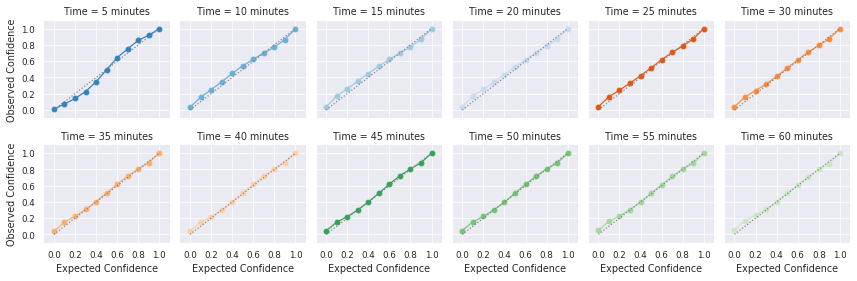

In [ ]:
sns.set_theme()
sns.set_context("paper")
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(calibration_data, col="Time", hue="Time", palette="tab20c",
                     col_wrap=6, height=2)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "Expected Confidence", "Observed Confidence", marker="o")

# Adjust the tick positions and labels
grid.set(xticks=[0, 0.2, 0.4, 0.6, 0.8, 1], yticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
         xlim=(-.1, 1.1), ylim=(-.1, 1.1))

for ax in grid.axes.flat:
    x = np.linspace(0, 1, 11)
    y = x
    ax.plot(x, y, linestyle=':', color='gray')

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

plt.savefig(foldername + 'calibration.pdf', 
           dpi=300)

In [ ]:
for i in range(12):
  print("For t = {0} shaprness is {1:.3f}".format((i+1)*5, np.mean(sharpness[i])))
sharpness_values = np.array([np.mean(sharpness[i]) for i in range(12)])

For t = 5 shaprness is 32.597
For t = 10 shaprness is 49.202
For t = 15 shaprness is 94.740
For t = 20 shaprness is 162.012
For t = 25 shaprness is 254.966
For t = 30 shaprness is 373.578
For t = 35 shaprness is 528.803
For t = 40 shaprness is 698.334
For t = 45 shaprness is 814.279
For t = 50 shaprness is 928.274
For t = 55 shaprness is 1031.797
For t = 60 shaprness is 1115.429


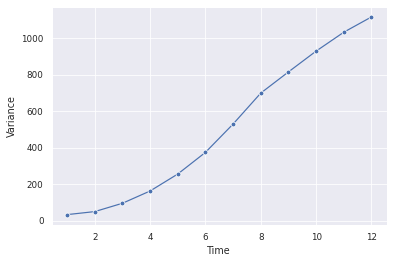

In [ ]:
ax = sns.lineplot(x = range(1, 13), y = sharpness_values, marker="o")
ax.set(xlabel="Time", ylabel="Variance")

plt.savefig(foldername + 'sharpness.pdf', dpi=300)

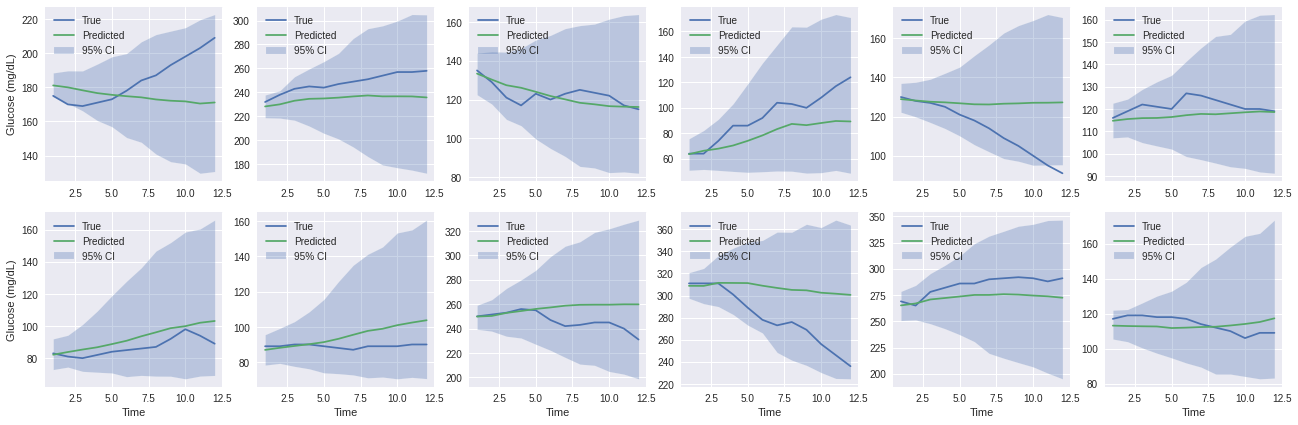

In [ ]:
def subplt(fig, index, y, yhat):
  ax = fig.add_subplot(2, 6, index)
  quants = np.quantile(yhat[0, :, :], q=[0.025, 0.975], axis=1) 
  mean = np.mean(yhat[0, :, :], axis=1)
  ax.plot(range(1,13), y[0, :], label = "True")
  ax.plot(range(1,13), mean, label = "Predicted")
  if index > 6:
    ax.set(xlabel="Time")
  if index == 1 or index == 7:
    ax.set(ylabel="Glucose (mg/dL)")
  ax.fill_between(range(1,13), quants[0], quants[1], alpha=0.3, label = "95% CI")
  ax.legend(loc='upper left')

plt.style.use("seaborn")
fig = plt.figure()
fig.set_size_inches(18, 6)
fig.subplots_adjust(hspace=0.2, wspace=0.4) 

sample = [1000, 3000, 4105, 
          5000, 6000, 7000, 
          7500, 9000, 10000,
          11000, 12000, 12500]
for i in range(1, 13):
  subplt(fig, i, trues[sample[i-1]], preds[sample[i-1]])

plt.tight_layout()
plt.savefig(foldername + 'confidence.pdf', dpi=300)

In [ ]:
with open(foldername + 'trues.pkl', 'wb') as f:
    pickle.dump(trues, f)
with open(foldername + 'preds.pkl', 'wb') as f:
    pickle.dump(preds, f)
with open(foldername + 'sharpness.pkl', 'wb') as f:
    pickle.dump(sharpness, f)
with open(foldername + 'calibration.pkl', 'wb') as f:
    pickle.dump(calibration, f)

In [ ]:
file = open(foldername + "logs-eval/calibration.pkl",'rb')
calibration = pickle.load(file)
file.close()

file = open(foldername + "logs-eval/preds.pkl",'rb')
preds = pickle.load(file)
file.close()

file = open(foldername + "logs-eval/trues.pkl",'rb')
trues = pickle.load(file)
file.close()

file = open(foldername + "logs-eval/sharpness.pkl",'rb')
sharpness = pickle.load(file)
file.close()